In [17]:
# About the Dataset

import os

print("Number of Images with Mask: ",len(os.listdir(r'C:\Users\user\Desktop\Face-Mask-Detection-Using-Hardware\dataset\with_mask')))
print("Number of Images without Mask: ",len(os.listdir(r'C:\Users\user\Desktop\Face-Mask-Detection-Using-Hardware\dataset\without_mask')))

Number of Images with Mask:  1915
Number of Images without Mask:  1975


In [18]:
# Data Preprocessing

import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

DATASET_DIRECTORY = r"C:\Users\user\Desktop\Face-Mask-Detection-Using-Hardware\dataset"
TYPES = ["with_mask", "without_mask"]

# All the Images Array will be appended in data list, whereas, the label of images(with_mask or without_mask) will be appended in labels
data = []
labels = []

print("Loading Images present our dataset!")

for dir_type in TYPES:
    path = os.path.join(DATASET_DIRECTORY,dir_type)
    print(path);
    #listdir(path) function will list down all the diretories in the path specified
    for img in os.listdir(path):
        image_path = os.path.join(path,img)
        
        #Loading Image and setting it's target size to 224x224
        image = load_img(image_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(dir_type)

# We've got the data as numerical values, however, the labels are still alphabetical values
# Thus we will convert them into categorical variables using LabelBinarizer from sklearn library

#This is performing BINARY ENCODING on labels
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype = "float32")
labels = np.array(labels)

print("Data Preprocessing Completed!")

Loading Images present our dataset!
C:\Users\user\Desktop\Face-Mask-Detection-Using-Hardware\dataset\with_mask


C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


C:\Users\user\Desktop\Face-Mask-Detection-Using-Hardware\dataset\without_mask
Data Preprocessing Completed!


In [19]:
#Splitting data into Training and Testing Data

from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.15, stratify = labels, random_state = 42)

print("Data Split into Training and Testing Data!")

Data Split into Training and Testing Data!


In [20]:
#Data Augmentation: Constructing the Training Image Generator
#This kind of creates many images from a single image by changing some of their properties

from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.15, shear_range=0.15,
horizontal_flip=True, fill_mode="nearest")

print("Data Augmentation Completed!")

Data Augmentation Completed!


In [21]:
#Loading MobileNetV2 to create a base model for better results

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

print("Base Model Completed!")

Base Model Completed!


In [22]:
# We will construct the headModel that will be placed on top of the baseModel !! (THIS WILL BECOME THE MODEL THAT WE WILL TRAIN)

from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

print("Head Model Created!")

model = Model(inputs=baseModel.input, outputs=headModel)

print("Final Model Ready for training!")

Head Model Created!
Final Model Ready for training!


Model Compilation started!
Model Compilation completed!
Head Training started!
Epoch 1/20
103/103 [==============================] - 75s 733ms/step - loss: 0.3867 - accuracy: 0.8320 - val_loss: 0.1119 - val_accuracy: 0.9726
Epoch 2/20
103/103 [==============================] - 79s 772ms/step - loss: 0.1447 - accuracy: 0.9478 - val_loss: 0.0667 - val_accuracy: 0.9863
Epoch 3/20
103/103 [==============================] - 97s 942ms/step - loss: 0.0964 - accuracy: 0.9633 - val_loss: 0.0503 - val_accuracy: 0.9863
Epoch 4/20
103/103 [==============================] - 118s 1s/step - loss: 0.0861 - accuracy: 0.9701 - val_loss: 0.0434 - val_accuracy: 0.9897
Epoch 5/20
103/103 [==============================] - 119s 1s/step - loss: 0.0679 - accuracy: 0.9771 - val_loss: 0.0391 - val_accuracy: 0.9897
Epoch 6/20
103/103 [==============================] - 120s 1s/step - loss: 0.0645 - accuracy: 0.9762 - val_loss: 0.0376 - val_accuracy: 0.9897
Epoch 7/20
103/103 [==============================] - 117

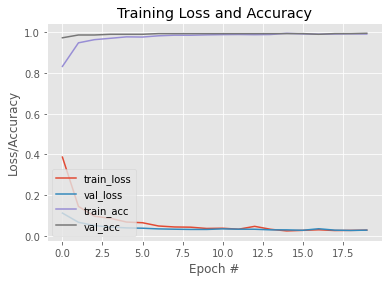

In [23]:
from tensorflow.keras.optimizers import Adam

# Initializing Learning Rate, Number of Epochs to train for, Batch Size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# Freeze all the layers of baseModel which will not update during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# Compiling the model
print("Model Compilation started!")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Model Compilation completed!")

# Train the head of the network
print("Head Training started!")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), 
              validation_steps=len(testX) // BS, epochs=EPOCHS)
print("Head Training completed!")

from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

print("Network Evaluation!")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print("Classification Report after testing!")
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=binarizer.classes_))

print("Saving the model named mask_detector.model to disc")
model.save("mask_detector.model", save_format="h5")

# Epoch VS Accuracy Curve
N = EPOCHS
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

plt.legend(loc="lower left")

print("Saving EPOCH vs Accuracy Plot to disc!")
plt.savefig("epoch_vs_accuracy_plot.png")

print("Model Created!")